# Scraping the top repositories for Topics on GitHub

- Web scraping (or data scraping) is a technique used to collect content and data from the internet. This data is usually saved in a local file so that it can be manipulated and analyzed as needed.
- GitHub is a code hosting platform for version control and collaboration. It lets you and others work together on projects from anywhere. We are trying to scrape the top topics and their repositories.
- Tools( Python, requests, BeautifulSoup, Pandas)


Here are the steps we'll follow:

- We're going to scrape https://github.com/topics
- We'll get a list of topics. For each topic, we'll get topic title, topic page URL and topic description
- For each topic, we'll get the top 25 repositories in the topic from the topic page
- For each repository, we'll grab the repo name, username, stars and repo URL
- For each topic we'll create a CSV file in the following format:

```
Repo Name,Username,Stars,Repo URL
three.js,mrdoob,69700,https://github.com/mrdoob/three.js
libgdx,libgdx,18300,https://github.com/libgdx/libgdx
```

## Scrape the list of topics from Github

- use requests to downlaod the page
- user BS4 to parse and extract information
- convert to a Pandas dataframe

Let's write a function to download the page.

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import os

In [2]:

def get_topics_page():
    
    topics_url = 'https://github.com/topics'
    #Download the page
    response = requests.get(topics_url)
     #Check for successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    
     #Parse using BeautifulSoup
    doc = BeautifulSoup(response.text, 'html.parser')
    return doc

In [3]:
doc = get_topics_page()

Let us look at what we need to fetch from 'https://github.com/topics' page

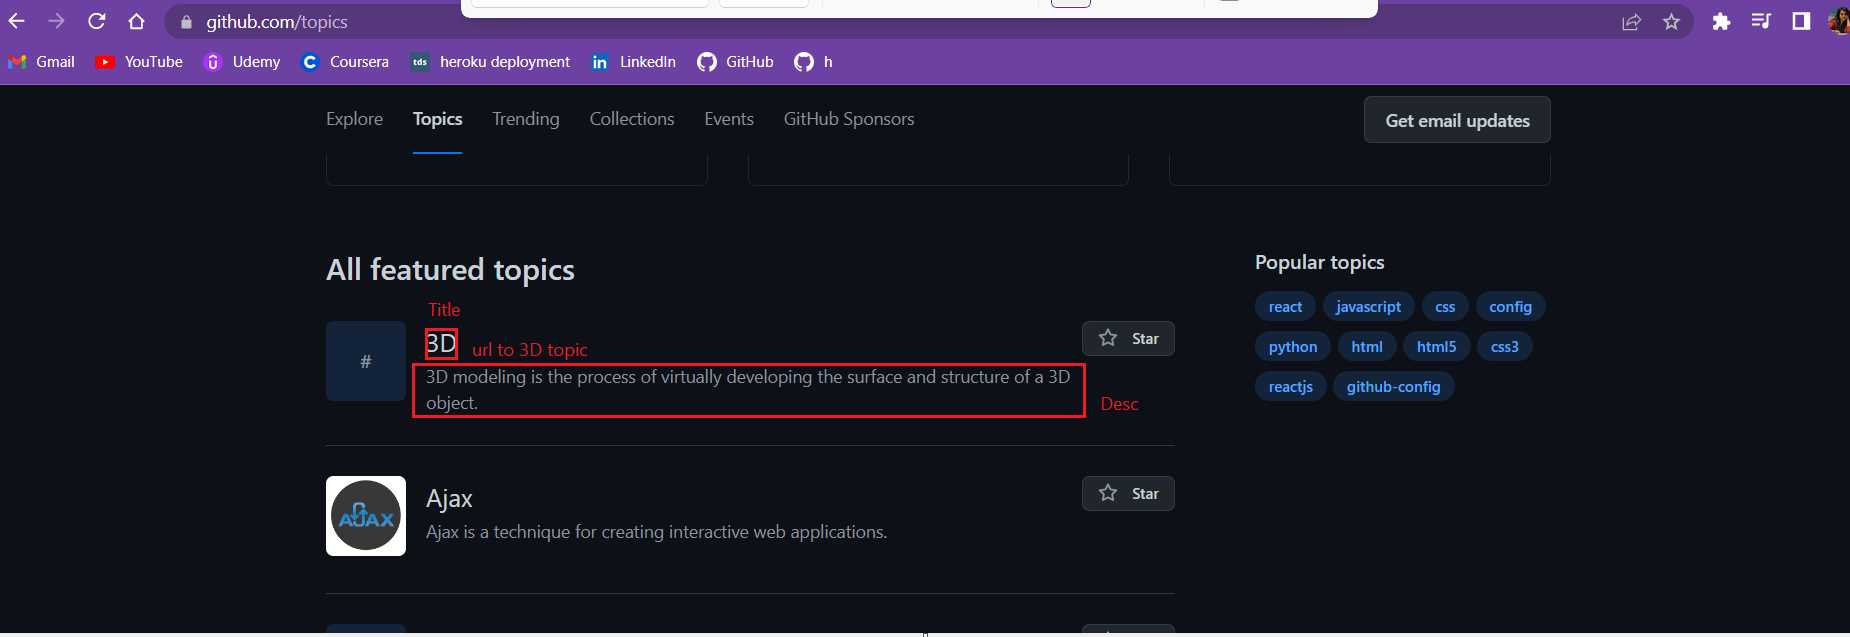

Let's create some helper functions to parse information from the page.

To get topic titles, we can pick `p` tags with the `class` ...

![image](https://i.imgur.com/OnzIdyP.png)

In [4]:
def get_topic_titles(doc):
    selection_class = 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_title_tags = doc.find_all('p', {'class': selection_class})
    topic_titles = []
    for tag in topic_title_tags:
        topic_titles.append(tag.text)
    return topic_titles

`get_topic_titles` can be used to get the list of titles

In [5]:
titles = get_topic_titles(doc)

In [6]:
len(titles)

30

In [7]:
titles[:5]

['3D', 'Ajax', 'Algorithm', 'Amp', 'Android']

Similarly we have defined functions for descriptions and URLs.

In [8]:
def get_topic_descs(doc):
    desc_selector = 'f5 color-fg-muted mb-0 mt-1'
    topic_desc_tags = doc.find_all('p', {'class': desc_selector})
    topic_descs = []
    for tag in topic_desc_tags:
        topic_descs.append(tag.text.strip())
    return topic_descs

In [9]:
descs=get_topic_descs(doc)
descs[:5]

['3D modeling is the process of virtually developing the surface and structure of a 3D object.',
 'Ajax is a technique for creating interactive web applications.',
 'Algorithms are self-contained sequences that carry out a variety of tasks.',
 'Amp is a non-blocking concurrency library for PHP.',
 'Android is an operating system built by Google designed for mobile devices.']

In [10]:
def get_topic_urls(doc):
    topic_link_tags = doc.find_all('a', {'class': 'no-underline flex-1 d-flex flex-column'})
    topic_urls = []
    base_url = 'https://github.com'
    for tag in topic_link_tags:
        topic_urls.append(base_url + tag['href'])
    return topic_urls

In [11]:
urls=get_topic_urls(doc)
urls[:5]

['https://github.com/topics/3d',
 'https://github.com/topics/ajax',
 'https://github.com/topics/algorithm',
 'https://github.com/topics/amphp',
 'https://github.com/topics/android']

### Let's put this all together into a single function for all 6 pages

In [12]:
def scrape_topics():
    df1 = pd.DataFrame(columns = ['title', 'description', 'url'])
    for page in range(1,7):
        topics_url = "https://github.com/topics?page={page}".format(page=page)

        #Download the page
        response = requests.get(topics_url)
         #Check for successful response
        if response.status_code != 200:
            raise Exception('Failed to load page {}'.format(topic_url))

         #Parse using BeautifulSoup
        doc= BeautifulSoup(response.text, 'html.parser')

        topics_dict = {
        'title': get_topic_titles(doc),
        'description': get_topic_descs(doc),
        'url': get_topic_urls(doc)
        }

        df1=pd.concat([df1,pd.DataFrame(topics_dict)],ignore_index=True)
    return (df1)

In [13]:
topic_df= scrape_topics()

In [14]:
topic_df.head()

,title,description,url
0,3D,3D modeling is the process of virtually develo...,https://github.com/topics/3d
1,Ajax,Ajax is a technique for creating interactive w...,https://github.com/topics/ajax
2,Algorithm,Algorithms are self-contained sequences that c...,https://github.com/topics/algorithm
3,Amp,Amp is a non-blocking concurrency library for ...,https://github.com/topics/amphp
4,Android,Android is an operating system built by Google...,https://github.com/topics/android


In [15]:
topic_df.count()

title          180
description    180
url            180
dtype: int64

#### Creating CSV

In [16]:
topic_df.to_csv('topics.csv',index=None)

## Get the top 40 repositories from every topic page



Let's check what we need to fetch from topic pages

example- 'https://github.com/topics/3d'

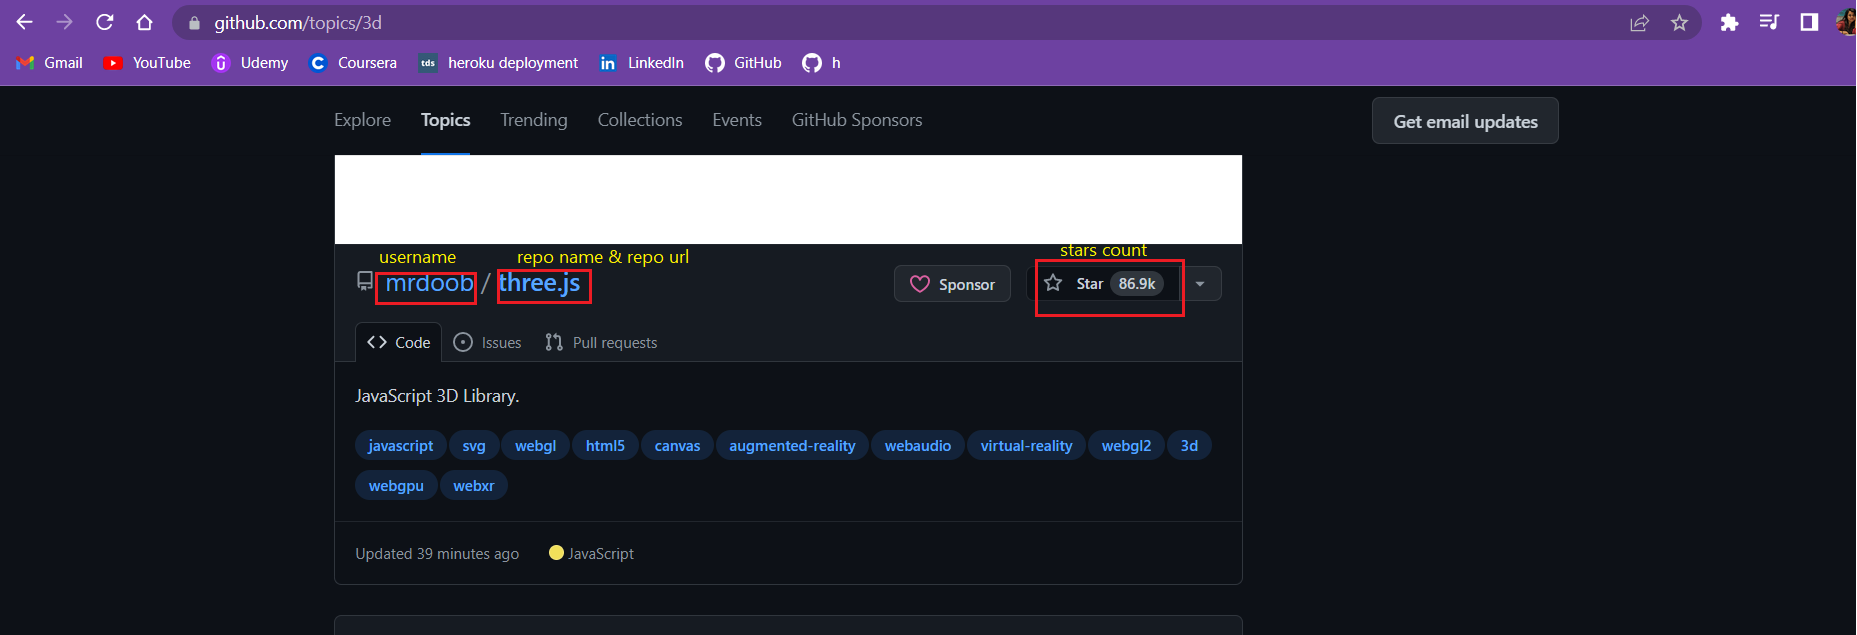

In [17]:
def get_topic_page(topic_url):
    # Download the page
    response = requests.get(topic_url)
    # Check successful response
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(topic_url))
    # Parse using Beautiful soup
    topic_doc = BeautifulSoup(response.text, 'html.parser')
    return topic_doc

In [18]:
doc = get_topic_page('https://github.com/topics/3d')

In [19]:
#Function to get number of stars 
def parse_star_count(stars):
    stars=stars.strip()
    if stars[-1]=='k':
        return int(float(stars[:-1])*1000)
    return(int(stars))

In [20]:
base_url="https://github.com"

In [21]:
def get_repo_info(h1_tag, star_tag):
    # returns all the required info about a repository
    a_tags = h1_tag.find_all('a')
    username = a_tags[0].text.strip()
    repo_name = a_tags[1].text.strip()
    repo_url =  base_url + a_tags[1]['href']
    stars = parse_star_count(star_tag.text.strip())
    return username, repo_name, stars, repo_url

In [22]:
def get_topic_repos(topic_doc):
    # Get the h1 tags containing repo title, repo URL and username
    repo_tags = topic_doc.find_all('h3',{'class':'f3 color-fg-muted text-normal lh-condensed'})

    # Get star tags
    star_tags=topic_doc.find_all('span',{'class':'Counter js-social-count'})
    
    topic_repos_dict = { 'username': [], 'repo_name': [], 'stars': [],'repo_url': []}

    # Get repo info
    for i in range(len(repo_tags)):
        repo_info = get_repo_info(repo_tags[i], star_tags[i])
        topic_repos_dict['username'].append(repo_info[0])
        topic_repos_dict['repo_name'].append(repo_info[1])
        topic_repos_dict['stars'].append(repo_info[2])
        topic_repos_dict['repo_url'].append(repo_info[3])
        
    return pd.DataFrame(topic_repos_dict)

In [98]:
def scrape_topic(topic_url, path,):
    
#     if os.path.exists(path):
#         print("The file {} already exists. Skipping...".format(path))
#         return
    topic_df = get_topic_repos(get_topic_page(topic_url))
    return topic_df
    #topic_df.to_csv(path, index=None)

## Putting it all together

- We have a funciton to get the list of topics
- We have a function to create a CSV file for scraped repos from a topics page
- Let's create a function to put them together

In [105]:
def scrape_topics_repos():
    
    print('Scraping list of topics')
    topics_df = scrape_topics()
    
    os.makedirs('Dataset', exist_ok=True)
    for index, row in topics_df.iterrows():
        path='Dataset/{}.csv'.format(row['title'])
        #Creating empty dataframe
        df_merge= pd.DataFrame(columns = ['username', 'repo_name', 'stars','repo_url'])
        
        print('Scraping top repositories for "{}"'.format(row['title']))
        
        if os.path.exists(path):
                print("The file {} already exists. Skipping...".format(path))
        else:
            for page in range(1,3):
            
                #scraping data from topic pages
                print("Page No:" + str(page))
                
                topic_df=scrape_topic(row['url'] +'?page={}'.format(str(page)),'Dataset/{}{}.csv'.format((row['title']),page))

                #Merging dataframes for two pages that is collecting 40 records(20 from page 1 and 20 from page 2)
                df_merge=pd.concat([topic_df,df_merge],ignore_index=True)


                #Converting into a csv
                df_merge.to_csv(path, index=None)

            
            
           
            
            

Let's run it to scrape the top repos for the all the topics on the first page of https://github.com/topics

In [115]:
scrape_topics_repos()

Scraping list of topics
Scraping top repositories for "3D"
The file Dataset/3D.csv already exists. Skipping...
Scraping top repositories for "Ajax"
The file Dataset/Ajax.csv already exists. Skipping...
Scraping top repositories for "Algorithm"
The file Dataset/Algorithm.csv already exists. Skipping...
Scraping top repositories for "Amp"
The file Dataset/Amp.csv already exists. Skipping...
Scraping top repositories for "Android"
The file Dataset/Android.csv already exists. Skipping...
Scraping top repositories for "Angular"
The file Dataset/Angular.csv already exists. Skipping...
Scraping top repositories for "Ansible"
The file Dataset/Ansible.csv already exists. Skipping...
Scraping top repositories for "API"
The file Dataset/API.csv already exists. Skipping...
Scraping top repositories for "Arduino"
The file Dataset/Arduino.csv already exists. Skipping...
Scraping top repositories for "ASP.NET"
The file Dataset/ASP.NET.csv already exists. Skipping...
Scraping top repositories for "Ato

The file Dataset/MongoDB.csv already exists. Skipping...
Scraping top repositories for "Mongoose"
The file Dataset/Mongoose.csv already exists. Skipping...
Scraping top repositories for "Monitoring"
The file Dataset/Monitoring.csv already exists. Skipping...
Scraping top repositories for "MvvmCross"
The file Dataset/MvvmCross.csv already exists. Skipping...
Scraping top repositories for "MySQL"
The file Dataset/MySQL.csv already exists. Skipping...
Scraping top repositories for "NativeScript"
The file Dataset/NativeScript.csv already exists. Skipping...
Scraping top repositories for "Nim"
The file Dataset/Nim.csv already exists. Skipping...
Scraping top repositories for "Natural language processing"
The file Dataset/Natural language processing.csv already exists. Skipping...
Scraping top repositories for "Node.js"
The file Dataset/Node.js.csv already exists. Skipping...
Scraping top repositories for "NoSQL"
The file Dataset/NoSQL.csv already exists. Skipping...
Scraping top repositorie

We can check that the CSVs were created properly

In [116]:
pd.read_csv('Dataset/Compiler.csv')

,username,repo_name,stars,repo_url
0,compiler-explorer,compiler-explorer,12000,https://github.com/compiler-explorer/compiler-...
1,gopherjs,gopherjs,11600,https://github.com/gopherjs/gopherjs
2,apache,tvm,8800,https://github.com/apache/tvm
3,numba,numba,8000,https://github.com/numba/numba
4,Nuitka,Nuitka,7700,https://github.com/Nuitka/Nuitka
5,aalhour,awesome-compilers,7200,https://github.com/aalhour/awesome-compilers
6,BuilderIO,mitosis,7200,https://github.com/BuilderIO/mitosis
7,JetBrains,kotlin-native,7100,https://github.com/JetBrains/kotlin-native
8,elm,compiler,7000,https://github.com/elm/compiler
9,DoctorWkt,acwj,7000,https://github.com/DoctorWkt/acwj


In [117]:
pd.read_csv('Dataset/Xamarin.csv')

,username,repo_name,stars,repo_url
0,microcharts-dotnet,Microcharts,1800,https://github.com/microcharts-dotnet/Microcharts
1,NLua,NLua,1700,https://github.com/NLua/NLua
2,xamarin,ios-samples,1600,https://github.com/xamarin/ios-samples
3,xamarin,Essentials,1500,https://github.com/xamarin/Essentials
4,luberda-molinet,FFImageLoading,1400,https://github.com/luberda-molinet/FFImageLoading
5,microsoft,AdaptiveCards,1400,https://github.com/microsoft/AdaptiveCards
6,jamesmontemagno,Xamarin.Plugins,1300,https://github.com/jamesmontemagno/Xamarin.Plu...
7,Baseflow,LottieXamarin,1200,https://github.com/Baseflow/LottieXamarin
8,moonsharp-devs,moonsharp,1200,https://github.com/moonsharp-devs/moonsharp
9,lbugnion,mvvmlight,1100,https://github.com/lbugnion/mvvmlight
